# Purpose

### 2021-11-23
In this notebook I'll select the clusters for the SFW listing below experiments

In one sheet include BOTH subreddit names & subreddit IDs.

TODO: also add place logic (e.g., add direction to: 
- city, state, country subreddits.


### Updates



# Imports & notebook setup

In [1]:
%load_ext google.colab.data_table

In [2]:
%load_ext autoreload
%autoreload 2

In [15]:
# colab auth for BigQuery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [4]:
# Attach google drive & import my python utility functions
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import sys
l_paths_to_append = [
    '/content/gdrive/MyDrive/Colab Notebooks',

    # need to append the path to subclu so that colab can import things properly
    '/content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n'
]
for path_ in l_paths_to_append:
    if path_ in sys.path:
        sys.path.remove(path_)
    print(f"Appending: {path_}")
    sys.path.append(path_)

Mounted at /content/gdrive
Appending: /content/gdrive/MyDrive/Colab Notebooks
Appending: /content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n


In [5]:
## install subclu & libraries needed to read parquet files from GCS

!pip install -e "/content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n/" --quiet

     |████████████████████████████████| 10.1 MB 4.9 MB/s 
     |████████████████████████████████| 14.2 MB 32.2 MB/s 
     |████████████████████████████████| 965 kB 38.6 MB/s 
     |████████████████████████████████| 144 kB 73.8 MB/s 
     |████████████████████████████████| 285 kB 34.6 MB/s 
     |████████████████████████████████| 13.2 MB 38.3 MB/s 
     |████████████████████████████████| 79.9 MB 96 kB/s 
     |████████████████████████████████| 132 kB 64.8 MB/s 
     |████████████████████████████████| 715 kB 62.5 MB/s 
     |████████████████████████████████| 74 kB 2.8 MB/s 
     |████████████████████████████████| 112 kB 57.7 MB/s 
     |████████████████████████████████| 180 kB 52.9 MB/s 
     |████████████████████████████████| 58 kB 5.7 MB/s 
     |████████████████████████████████| 1.1 MB 55.3 MB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 146 kB 58.8 MB/s 
     |████████████████████████████████| 596 kB 47.8 MB/s 
     |█████████████

In [6]:
# Install needed to load data from GCS, for some reason not included in subclu?
!pip install gcsfs --quiet

     |████████████████████████████████| 1.1 MB 7.8 MB/s 
     |████████████████████████████████| 271 kB 47.7 MB/s 
     |████████████████████████████████| 160 kB 57.4 MB/s 
     |████████████████████████████████| 192 kB 46.5 MB/s 


In [7]:
# Need to get latest version of gspread to read & write to google sheets
!pip install --upgrade gspread --quiet

In [8]:
# auth for google sheets
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [9]:
# Regular Imports
import os
from datetime import datetime

from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted


# os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-science-prod-218515'
os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-prod-165221'

In [13]:
# subclu imports

# For reloading, need to force-delete some imported items
try:
    del subclu
    del create_dynamic_clusters, convert_distance_or_ab_to_list_for_fpr
except Exception:
    pass

import subclu
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.models.clustering_utils import (
    create_dynamic_clusters,
    convert_distance_or_ab_to_list_for_fpr
)


setup_logging()
print_lib_versions([gspread, pd, np])

python		v 3.7.12
===
gspread		v: 4.0.1
pandas		v: 1.1.5
numpy		v: 1.19.5


# Load subreddit metadata

This data is already in bigQuery so read it straight from there. We'll use it to filter out geo-relevant (German) subs.

Also add the latest ratings so that we can filter based on those.

## SQL query

In [16]:
%%time

sql_geo_and_languages = f"""
-- select DE subreddits + get latest rating

SELECT 
    sl.subreddit_id
    , sl.subreddit_name
    , r.rating
    -- , r.subrating
    , r.version

    , slo.verdict
    , slo.quarantine

    , geo.country_name
    , geo.users_percent_in_country
    -- , sl.geo_relevant_countries
    , ambassador_subreddit
    , posts_for_modeling_count

    , primary_post_language
    , primary_post_language_percent
    , secondary_post_language
    , secondary_post_language_percent

    , geo_relevant_country_count
    , geo_relevant_country_codes
    , geo_relevant_subreddit

FROM `reddit-employee-datasets.david_bermejo.subclu_v0040_subreddit_languages` sl
LEFT JOIN (
    SELECT * FROM `data-prod-165221.ds_v2_postgres_tables.subreddit_lookup`
    # Look back 2 days because looking back 1-day could be an empty partition
    WHERE dt = (CURRENT_DATE() - 2)
) AS slo
    ON slo.subreddit_id = sl.subreddit_id
LEFT JOIN (
    SELECT * FROM `reddit-employee-datasets.david_bermejo.subclu_geo_subreddits_20210922`
    WHERE country_name = 'Germany'
) AS geo 
    ON sl.subreddit_id = geo.subreddit_id
LEFT JOIN (
    SELECT * FROM ds_v2_subreddit_tables.subreddit_ratings
    WHERE DATE(pt) = (CURRENT_DATE() - 2)
) AS r
    ON r.subreddit_id = sl.subreddit_id

    
WHERE 1=1
    -- AND r.version = 'v2'
    -- AND COALESCE(r.rating, '') IN ('pg', 'pg13', 'g')
    AND COALESCE(slo.verdict, '') != 'admin-removed'
    AND COALESCE(slo.quarantine, false) != true
    AND (
        sl.geo_relevant_countries LIKE '%Germany%'
        OR sl.ambassador_subreddit = True
    )

ORDER BY users_percent_in_country ASC -- subreddit_name, ambassador_subreddit
;
"""

client = bigquery.Client()
df_geo_and_lang = client.query(sql_geo_and_languages).to_dataframe()
print(df_geo_and_lang.shape)

(817, 17)
CPU times: user 105 ms, sys: 13.8 ms, total: 119 ms
Wall time: 7.58 s


## Check data with geo + language information

In [17]:
df_geo_and_lang.head()

,subreddit_id,subreddit_name,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,posts_for_modeling_count,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit
0,t5_4ckovw,buehne,None,None,None,False,None,NaN,True,9.0,German,0.333333,Danish,0.111111,NaN,None,False
1,t5_4p0iav,de_events,None,None,None,False,None,NaN,True,1.0,German,1.000000,None,NaN,NaN,None,False
2,t5_2otu32,nikolacorporation,pg,v3,None,False,Germany,0.160008,False,188.0,English,0.920213,Estonian,0.010638,1.0,DE,True
3,t5_vwvbb,vanmoofbicycle,pg,v1,None,False,Germany,0.160199,False,305.0,English,0.963934,None,NaN,1.0,DE,True
4,t5_2rq3g,trackmania,pg,v1,None,False,Germany,0.160615,False,958.0,English,0.927975,None,NaN,1.0,DE,True


In [18]:
df_geo_and_lang.tail()

,subreddit_id,subreddit_name,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,posts_for_modeling_count,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit
812,t5_2tz7b,braunschweig,None,None,None,False,Germany,0.956430,False,28.0,German,0.892857,English,0.071429,1.0,DE,True
813,t5_3255n,duschgedanken,None,None,None,False,Germany,0.956434,True,90.0,German,1.000000,None,NaN,1.0,DE,True
814,t5_2w4vt,bielefeld,None,None,None,False,Germany,0.957314,False,27.0,German,0.925926,English,0.037037,1.0,DE,True
815,t5_2ty5z,bundeswehr,None,None,None,False,Germany,0.959926,False,254.0,German,0.960630,English,0.031496,1.0,DE,True
816,t5_4o0ba2,nachthimmel,None,None,None,False,Germany,1.000000,True,18.0,German,0.833333,English,0.111111,NaN,None,False


# Load model labels

~Ideally we could just pull the configuration data from github~

The clusters now live in a big Query table and have standardized names, so pull the data from there.

## Pull data from BigQuery


In [19]:
%%time

sql_labels = f"""
-- select subreddit clusters from bigQuery

SELECT
    sc.subreddit_id
    , sc.subreddit_name
    , nt.primary_topic

    , sc.* EXCEPT(subreddit_id, subreddit_name)
FROM `reddit-employee-datasets.david_bermejo.subclu_v0040_subreddit_clusters_c_a` sc
    LEFT JOIN (
        -- New view should be visible to all, but still comes from cnc_taxonomy_cassandra_sync
        SELECT * FROM `data-prod-165221.cnc.shredded_crowdsource_topic_and_rating`
        WHERE DATE(pt) = (CURRENT_DATE() - 2)
    ) AS nt
        ON sc.subreddit_id = nt.subreddit_id
;
"""

client = bigquery.Client()
df_labels = client.query(sql_labels).to_dataframe()
print(df_labels.shape)

(19053, 22)
CPU times: user 1.3 s, sys: 280 ms, total: 1.58 s
Wall time: 7.41 s


In [20]:
df_labels.head()

,subreddit_id,subreddit_name,primary_topic,model_distance_order,posts_for_modeling_count,primary_topic_0921,k014_label,k030_label,k052_label,k100_label,k248_label,k351_label,k405_label,k014_majority_primary_topic,k030_majority_primary_topic,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,table_creation_date,mlflow_run_uuid
0,t5_2t32k,wendys,"Business, Economics, and Finance",13000,123,"Business, Economics, and Finance",11,20,34,60,155,218,255,Food and Drink,Food and Drink,Food and Drink,Food and Drink,Food and Drink,Food and Drink,Food and Drink,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71
1,t5_2stay,kfc,Food and Drink,13001,113,Food and Drink,11,20,34,60,155,218,255,Food and Drink,Food and Drink,Food and Drink,Food and Drink,Food and Drink,Food and Drink,Food and Drink,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71
2,t5_2vgdv,popeyes,Food and Drink,13002,66,Food and Drink,11,20,34,60,155,218,255,Food and Drink,Food and Drink,Food and Drink,Food and Drink,Food and Drink,Food and Drink,Food and Drink,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71
3,t5_3fqzn,hotones,Podcasts and Streamers,13003,130,Podcasts and Streamers,11,20,34,60,155,218,255,Food and Drink,Food and Drink,Food and Drink,Food and Drink,Food and Drink,Food and Drink,Food and Drink,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71
4,t5_2qmg9,hotsauce,Food and Drink,13004,718,Food and Drink,11,20,34,60,155,218,255,Food and Drink,Food and Drink,Food and Drink,Food and Drink,Food and Drink,Food and Drink,Food and Drink,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71


In [21]:
counts_describe(df_labels)

07:33:54 | INFO | "NumExpr defaulting to 2 threads."


,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"19,053","19,053",100.00%,0,0.00%
subreddit_name,object,"19,053","19,053",100.00%,0,0.00%
primary_topic,object,"16,129",52,0.32%,"2,924",15.35%
model_distance_order,int64,"19,053","19,053",100.00%,0,0.00%
posts_for_modeling_count,int64,"19,053","1,175",6.17%,0,0.00%
primary_topic_0921,object,"15,929",51,0.32%,"3,124",16.40%
k014_label,int64,"19,053",14,0.07%,0,0.00%
k030_label,int64,"19,053",30,0.16%,0,0.00%
k052_label,int64,"19,053",52,0.27%,0,0.00%
k100_label,int64,"19,053",100,0.52%,0,0.00%


# Keep only labels for DE subreddits


In [22]:
l_ix_subs = ['subreddit_name', 'subreddit_id']

df_labels_target = (
    df_labels
    .merge(
        df_geo_and_lang.drop(['posts_for_modeling_count'], axis=1),
        how='right',
        on=l_ix_subs,
    )
    .copy()
    .sort_values(by=['model_distance_order'], ascending=True)
)

# move some columns to the end of the file
l_cols_to_end = ['table_creation_date', 'mlflow_run_uuid']

df_labels_target = df_labels_target[
    df_labels_target.drop(l_cols_to_end, axis=1).columns.to_list() +
    l_cols_to_end
]
print(df_labels_target.shape)

(817, 36)


### Drop subs with too few posts

In the modeling process I drop subreddits with too few posts. We don't have recommendations for them, so let's drop them.

It would also not be a great experience to recommend dead subs.

In [25]:
print(f"{df_labels_target['model_distance_order'].isnull().sum():,.0f} <- subs to drop")
df_labels_target = df_labels_target[
    ~df_labels_target['model_distance_order'].isnull()
].copy()
df_labels_target['model_distance_order'] = df_labels_target['model_distance_order'].astype(int)

l_cols_label_de = [c for c in df_labels_target.columns if c.endswith('_label')]
df_labels_target[l_cols_label_de] = df_labels_target[l_cols_label_de].astype(int)

df_labels_target.shape

0 <- subs to drop


(784, 36)

In [26]:
style_df_numeric(
    df_labels_target.head(10),
    # rename_cols_for_display=True,
    pct_labels=['_percent_in_country', '_percent'],
    int_labels=None,
    pct_cols=['users_percent_in_country'],
    l_bar_simple=[c for c in df_labels_target.columns if '_label' in c]
)

,subreddit_id,subreddit_name,primary_topic,model_distance_order,posts_for_modeling_count,primary_topic_0921,k014_label,k030_label,k052_label,k100_label,k248_label,k351_label,k405_label,k014_majority_primary_topic,k030_majority_primary_topic,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit,table_creation_date,mlflow_run_uuid
33,t5_2roop,hardtechno,None,49,18,None,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,None,None,None,False,Germany,0,False,English,77.78%,Dutch,5.56%,1,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71
149,t5_2qziu,rappers,None,76,386,None,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,r,v2,admin-approved,False,Germany,0,False,English,81.87%,German,1.81%,1,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71
569,t5_2v7pv,germanrap,Music,77,705,Music,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,r,v2,None,False,Germany,1,False,German,71.49%,English,13.05%,1,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71
227,t5_2smd3,musik,None,85,23,None,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,None,None,None,False,Germany,1,False,German,82.61%,English,8.70%,1,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71
197,t5_39ea8,mgpmppjwfa,Music,89,25,Music,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,None,None,None,False,Germany,0,False,German,52.00%,English,8.00%,1,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71
241,t5_2t6i4,germusic,Music,95,179,Music,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,pg13,None,None,False,Germany,1,False,German,58.10%,English,21.23%,1,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71
541,t5_31l12,kollegah,Music,172,17,Music,1,1,1,2,2,2,2,Music,Music,Music,Music,Music,Music,Music,None,None,None,False,Germany,1,False,German,94.12%,Indonesian,5.88%,1,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71
316,t5_2ylk3,moneyboy,Music,173,19,Music,1,1,1,2,2,2,2,Music,Music,Music,Music,Music,Music,Music,None,None,None,False,Germany,1,False,German,84.21%,Danish,5.26%,1,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71
13,t5_2t36v,billytalent,Music,283,101,Music,1,1,1,2,4,4,4,Music,Music,Music,Music,Music,Music,Music,r,v1,None,False,Germany,0,False,English,99.01%,Somali,0.99%,1,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71
14,t5_35q0o,lindemann,Music,370,37,Music,1,1,1,2,4,4,4,Music,Music,Music,Music,Music,Music,Music,r,v2,None,False,Germany,0,False,English,91.89%,Danish,2.70%,1,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71


In [27]:
# style_df_numeric(
#     df_labels_target.tail(10),
#     # rename_cols_for_display=True,
#     l_bar_simple=[c for c in df_labels_target.columns if '_label' in c]
# )

# Filter out subs

The main use case for now are SFW subs, so let's save some QA time by excluding these subs:
- Exclude NSFW clusters
- Exclude place subs


We'll use the cluster labels to discard subreddits because 
- many of the DE subreddits don't have a `primary_topic`
- if the majority of subs for a subreddits are NSFW, then we wouldn't want to recommend those anyway

In [28]:
value_counts_and_pcts(
    df_labels_target['k405_majority_primary_topic'],
    top_n=15,
    reset_index=True,
    add_col_prefix=False,
    count_type='subreddits',
    return_df=False,
)

,k405_majority_primary_topic,subreddits_count,percent_of_subreddits,cumulative_percent_of_subreddits
0,Mature Themes and Adult Content,182,23.2%,23.2%
1,Place,66,8.4%,31.6%
2,Gaming,56,7.1%,38.8%
3,Funny/Humor,48,6.1%,44.9%
4,"Business, Economics, and Finance",41,5.2%,50.1%
5,Sports,39,5.0%,55.1%
6,Internet Culture and Memes,37,4.7%,59.8%
7,Politics,30,3.8%,63.6%
8,Podcasts and Streamers,30,3.8%,67.5%
9,Technology,28,3.6%,71.0%


In [29]:
value_counts_and_pcts(
    df_labels_target['primary_topic'],
    count_type='subreddits',
    reset_index=True,
    add_col_prefix=False,
)

,primary_topic,subreddits_count,percent_of_subreddits,cumulative_percent_of_subreddits
0,nan,297,37.9%,37.9%
1,Mature Themes and Adult Content,49,6.2%,44.1%
2,Gaming,45,5.7%,49.9%
3,Place,37,4.7%,54.6%
4,Internet Culture and Memes,35,4.5%,59.1%
5,Technology,32,4.1%,63.1%
6,Sports,29,3.7%,66.8%
7,"Business, Economics, and Finance",28,3.6%,70.4%
8,Funny/Humor,27,3.4%,73.9%
9,Learning and Education,16,2.0%,75.9%


In [31]:
print(f"{df_labels_target.shape} <- Shape before filtering")

l_manual_subs_to_remove = [
    'sexmeets1', 'fuck',
]

df_labels_target_clean = (
    df_labels_target[df_labels_target['k405_majority_primary_topic'] != 'Mature Themes and Adult Content']
)
print(f"{df_labels_target_clean.shape} <- Shape after dropping NSFW clusters")

l_sensitive_topics = [
    'Military', 'Gender', 'Addiction Support',
    'Medical and Mental Health', 'Sexual Orientation',
    'Culture, Race, and Ethnicity',
]
df_labels_target_clean = (
    df_labels_target_clean[
        ~df_labels_target_clean['k405_majority_primary_topic'].isin(l_sensitive_topics)
    ]
)
print(f"{df_labels_target_clean.shape} <- Shape after dropping Sensitive clusters")

df_labels_target_clean = (
    df_labels_target_clean[
        ~df_labels_target_clean['primary_topic'].isin(l_sensitive_topics)
    ]
)
print(f"{df_labels_target_clean.shape} <- Shape after dropping SENSITIVE subreddits")


df_labels_target_clean = (
    df_labels_target_clean[
        ~df_labels_target_clean['subreddit_name'].isin(l_manual_subs_to_remove)
    ]
)
print(f"{df_labels_target_clean.shape} <- Shape after dropping Manual list of subreddits")

print(f"  ** TODO: instead of excluding place subs, add logic to map hierarchy **")
# df_labels_target_clean = (
#     df_labels_target_clean[df_labels_target_clean['primary_topic'] != 'Place']
# )
# print(f"{df_labels_target_clean.shape} <- Shape after dropping Place subreddits")

(784, 36) <- Shape before filtering
(602, 36) <- Shape after dropping NSFW clusters
(587, 36) <- Shape after dropping Sensitive clusters
(581, 36) <- Shape after dropping SENSITIVE subreddits
(579, 36) <- Shape after dropping Manual list of subreddits
  ** TODO: instead of excluding place subs, add logic to map hierarchy **


# Create new clustering logic to resize clusters

We want to balance two things:
- prevent orphan subreddits
- prevent clusters that are too large to be meaningful

In order to do this at a country level, we'll be better off starting with smallest cluster size and roll up until we have at least N subreddits in one cluster.

For now, let's set the threshold at 5.

In [35]:
# let's exclude  k=014 because at that point the clusters are too generic
col_new_cluster_val = 'cluster_label'
col_new_cluster_name = 'cluster_label_k'
col_new_cluster_prim_topic = 'cluster_majority_primary_topic'

l_cols_labels = [c for c in df_labels_target_clean.columns 
                 if all([c != col_new_cluster_val, c.endswith('_label')])
                 ][1:]


try:
    df_labels_target = df_labels_target.drop([col_new_cluster_val, col_new_cluster_name, col_new_cluster_prim_topic],
                          axis=1)
    df_labels_target = df_labels_target.drop([c for c in df_labels_target.columns if c.endswith('_label_nested')],
                                             axis=1)
except KeyError:
    pass
try:
    df_labels_target_clean = df_labels_target_clean.drop(
        [col_new_cluster_val, col_new_cluster_name, col_new_cluster_prim_topic],
        axis=1
    )
    df_labels_target_clean = df_labels_target_clean.drop(
        [c for c in df_labels_target_clean.columns if c.endswith('_label_nested')],
        axis=1
    )
except KeyError:
    pass

df_labels_target_clean = create_dynamic_clusters(
    df_labels_target_clean,
    agg_strategy='aggregate_small_clusters',
    min_subreddits_in_cluster=4,
    l_cols_labels_input=l_cols_labels,
    col_new_cluster_val=col_new_cluster_val,
    col_new_cluster_prim_topic=col_new_cluster_prim_topic,
)

print(f"*** Dynamic clusters RAW ***")
df_labels_target = create_dynamic_clusters(
    df_labels_target,
    agg_strategy='aggregate_small_clusters',
    min_subreddits_in_cluster=3,
    l_cols_labels_input=l_cols_labels,
    col_new_cluster_val=col_new_cluster_val,
    col_new_cluster_name=col_new_cluster_name,
    col_new_cluster_prim_topic=col_new_cluster_prim_topic,
)

(151,) <- Shape of clusters below threshold
(146,) <- Shape of clusters below threshold
(131,) <- Shape of clusters below threshold
(53,) <- Shape of clusters below threshold
(25,) <- Shape of clusters below threshold
*** Dynamic clusters RAW ***
(156,) <- Shape of clusters below threshold
(150,) <- Shape of clusters below threshold
(126,) <- Shape of clusters below threshold
(58,) <- Shape of clusters below threshold
(26,) <- Shape of clusters below threshold


In [34]:
# df_labels_target_clean.head(10)

## Check if there are any single subreddits if we use cluster = 52

We want to avoid having clusters of one subreddit b/c that means we have nothing to recommend.

Looks like even at 52 there are some subreddits that are orphans.

In [37]:
df_lbl_counts52 = value_counts_and_pcts(
    df_labels_target_clean['k052_label'], top_n=None,
    reset_index=True,
    add_col_prefix=False,
    return_df=True,
).sort_values(by=['count'], ascending=False)

df_lbl_counts_dynamic = value_counts_and_pcts(
    df_labels_target_clean['cluster_label'], top_n=None,
    reset_index=True,
    add_col_prefix=False,
    return_df=True,
).sort_values(by=['count'], ascending=False)
df_lbl_counts_dynamic.shape

df_lbl_counts_dynamic_raw = value_counts_and_pcts(
    df_labels_target['cluster_label'], top_n=None,
    reset_index=True,
    add_col_prefix=False,
    return_df=True,
).sort_values(by=['count'], ascending=False)

style_df_numeric(
    pd.concat(
        [
            df_lbl_counts52['count'].describe().to_frame().rename(columns={'count': 'CLEAN-k052'}).T,
            df_lbl_counts_dynamic['count'].describe().to_frame().rename(columns={'count': 'CLEAN-dynamic_cluster'}).T,
            df_lbl_counts_dynamic_raw['count'].describe().to_frame().rename(columns={'count': 'RAW-dynamic_cluster'}).T,
        ]
    ),
    float_round=3,
)

,count,mean,std,min,25%,50%,75%,max
CLEAN-k052,43,13.465,13.854,1.000,3.500,7.000,19.000,54.000
CLEAN-dynamic_cluster,76,7.618,6.284,1.000,5.000,6.000,8.000,39.000
RAW-dynamic_cluster,108,7.259,6.957,1.000,4.000,5.000,7.000,39.000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


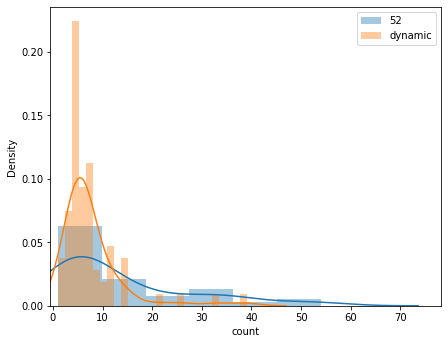

In [44]:
plt.figure(figsize=(7, 5.5))
ax = sns.distplot(df_lbl_counts52['count'], label='52', kde=True)
ax = sns.distplot(df_lbl_counts_dynamic['count'], label='dynamic', kde=True)
plt.legend()
ax.set_xlim(-.5, );

In [45]:
# style_df_numeric(df_lbl_counts52.head(10), l_bar_simple=['count', 'percent'])

In [46]:
# style_df_numeric(df_lbl_counts_dynamic.head(10), l_bar_simple=['count', 'percent'])

In [47]:
# ax = sns.displot(df_lbl_counts52['count'], label='52', kind='kde')
# ax = sns.displot(df_lbl_counts_dynamic['count'], label='dynamic', kind='kde')

In [48]:
l_orphan_cluster_ids = df_lbl_counts52[df_lbl_counts52['count'] <= 1]['k052_label'].values
print(len(l_orphan_cluster_ids))
l_subs_to_check_orphan = ['fitnessde', 'zelten']

df_labels_target_clean[df_labels_target_clean['k052_label'].isin(l_orphan_cluster_ids)]

2


,subreddit_id,subreddit_name,model_distance_order,posts_for_modeling_count,primary_topic_0921,cluster_label,cluster_label_k,cluster_majority_primary_topic,primary_topic,k014_label,k030_label,k052_label,k100_label,k248_label,k351_label,k405_label,k014_majority_primary_topic,k030_majority_primary_topic,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit,table_creation_date,mlflow_run_uuid,k030_label_nested,k052_label_nested,k100_label_nested,k248_label_nested,k351_label_nested,k405_label_nested
596,t5_35ipo,fitnessde,15011,26.0,Fitness and Nutrition,025,k030_label,Medical and Mental Health,Fitness and Nutrition,12,25,43,74,188,269,312,Medical and Mental Health,Medical and Mental Health,Fitness and Nutrition,Fitness and Nutrition,Fitness and Nutrition,Fitness and Nutrition,Fitness and Nutrition,pg,None,None,False,Germany,0.861554,False,German,1.000000,None,NaN,1.0,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,025,025-043,025-043-074,025-043-074-188,025-043-074-188-269,025-043-074-188-269-312
440,t5_4ognal,zelten,17047,62.0,Outdoors and Nature,028,k030_label,Place,Outdoors and Nature,13,28,48,89,222,318,367,Place,Place,Place,Music,Outdoors and Nature,Outdoors and Nature,Outdoors and Nature,None,None,None,False,Germany,0.801587,True,German,0.951613,French,0.016129,1.0,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,028,028-048,028-048-089,028-048-089-222,028-048-089-222-318,028-048-089-222-318-367


In [49]:
l_orphan_cluster_ids2 = df_lbl_counts_dynamic[df_lbl_counts_dynamic['count'] <= 1][col_new_cluster_val].values
print(len(l_orphan_cluster_ids2))

df_labels_target_clean[df_labels_target_clean[col_new_cluster_val].isin(l_orphan_cluster_ids2)]

2


,subreddit_id,subreddit_name,model_distance_order,posts_for_modeling_count,primary_topic_0921,cluster_label,cluster_label_k,cluster_majority_primary_topic,primary_topic,k014_label,k030_label,k052_label,k100_label,k248_label,k351_label,k405_label,k014_majority_primary_topic,k030_majority_primary_topic,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit,table_creation_date,mlflow_run_uuid,k030_label_nested,k052_label_nested,k100_label_nested,k248_label_nested,k351_label_nested,k405_label_nested
88,t5_361rcd,lessdougdemuro,4015,102.0,Cars and Motor Vehicles,007,k030_label,Podcasts and Streamers,Cars and Motor Vehicles,4,7,11,16,36,51,55,Internet Culture and Memes,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,None,None,None,False,Germany,0.201125,False,English,0.862745,Italian,0.019608,1.0,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,007,007-011,007-011-016,007-011-016-036,007-011-016-036-051,007-011-016-036-051-055
596,t5_35ipo,fitnessde,15011,26.0,Fitness and Nutrition,025,k030_label,Medical and Mental Health,Fitness and Nutrition,12,25,43,74,188,269,312,Medical and Mental Health,Medical and Mental Health,Fitness and Nutrition,Fitness and Nutrition,Fitness and Nutrition,Fitness and Nutrition,Fitness and Nutrition,pg,None,None,False,Germany,0.861554,False,German,1.000000,None,NaN,1.0,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,025,025-043,025-043-074,025-043-074-188,025-043-074-188-269,025-043-074-188-269-312


# Reshape distance data to include only subs in a cluster

For country-level it's fine to only limit based on cluster ID because we have so few subreddits in some countries. 

For other use cases we might want to limit by only top N subs within a given distance.

### Reshape: flatten topics into 1 row = 1 subreddit with counterpart/cluster subs

See utility function that does reshaping with one call.

In [50]:
%%time

df_target_to_target_list = convert_distance_or_ab_to_list_for_fpr(
    df_labels_target_clean,
    convert_to_ab=True,
    col_counterpart_count='counterpart_count',
    col_list_cluster_names='list_cluster_subreddit_names',
    col_list_cluster_ids='list_cluster_subreddit_ids',
    l_cols_for_seeds=None,
    l_cols_for_clusters=None,
    col_new_cluster_val=col_new_cluster_val,
    col_new_cluster_name=col_new_cluster_name,
    col_new_cluster_prim_topic=col_new_cluster_prim_topic,
    verbose=False,
)
df_target_to_target_list.shape

  (6794, 9) <- df_ab.shape after removing matches to self
  (577, 7) <- df_a_to_b.shape
CPU times: user 71.1 ms, sys: 234 µs, total: 71.3 ms
Wall time: 73.7 ms


In [51]:
df_target_to_target_list.head()

,subreddit_name_seed,subreddit_id_seed,cluster_label,cluster_label_k,counterpart_count,list_cluster_subreddit_names,list_cluster_subreddit_ids
0,hardtechno,t5_2roop,001-001-001-001-001-001,k405_label,5,"rappers, germanrap, musik, mgpmppjwfa, germusic","t5_2qziu, t5_2v7pv, t5_2smd3, t5_39ea8, t5_2t6i4"
1,rappers,t5_2qziu,001-001-001-001-001-001,k405_label,5,"hardtechno, germanrap, musik, mgpmppjwfa, germ...","t5_2roop, t5_2v7pv, t5_2smd3, t5_39ea8, t5_2t6i4"
2,germanrap,t5_2v7pv,001-001-001-001-001-001,k405_label,5,"hardtechno, rappers, musik, mgpmppjwfa, germusic","t5_2roop, t5_2qziu, t5_2smd3, t5_39ea8, t5_2t6i4"
3,musik,t5_2smd3,001-001-001-001-001-001,k405_label,5,"hardtechno, rappers, germanrap, mgpmppjwfa, ge...","t5_2roop, t5_2qziu, t5_2v7pv, t5_39ea8, t5_2t6i4"
4,mgpmppjwfa,t5_39ea8,001-001-001-001-001-001,k405_label,5,"hardtechno, rappers, germanrap, musik, germusic","t5_2roop, t5_2qziu, t5_2v7pv, t5_2smd3, t5_2t6i4"


In [52]:
df_target_to_target_list[
    df_target_to_target_list['subreddit_name_seed'].isin(l_subs_to_check_orphan)
]

,subreddit_name_seed,subreddit_id_seed,cluster_label,cluster_label_k,counterpart_count,list_cluster_subreddit_names,list_cluster_subreddit_ids
498,zelten,t5_4ognal,028,k030_label,1,reisende,t5_4rdyqv


In [53]:
df_labels_target_clean[df_labels_target_clean[col_new_cluster_val] == '012']

,subreddit_id,subreddit_name,model_distance_order,posts_for_modeling_count,primary_topic_0921,cluster_label,cluster_label_k,cluster_majority_primary_topic,primary_topic,k014_label,k030_label,k052_label,k100_label,k248_label,k351_label,k405_label,k014_majority_primary_topic,k030_majority_primary_topic,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit,table_creation_date,mlflow_run_uuid,k030_label_nested,k052_label_nested,k100_label_nested,k248_label_nested,k351_label_nested,k405_label_nested
346,t5_i0wle,kampfsport,9219,120.0,Sports,012,k030_label,Sports,Sports,7,12,21,36,93,132,151,Sports,Sports,Sports,Sports,Sports,Sports,Sports,None,None,admin-approved,False,Germany,0.739550,True,German,0.741667,English,0.141667,1.0,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,012,012-021,012-021-036,012-021-036-093,012-021-036-093-132,012-021-036-093-132-151
295,t5_3hik5,formel1,9261,284.0,Sports,012,k030_label,Sports,Sports,7,12,21,36,95,134,153,Sports,Sports,Sports,Sports,Sports,Sports,Sports,None,None,None,False,Germany,0.664234,True,German,0.855634,English,0.102113,1.0,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,012,012-021,012-021-036,012-021-036-095,012-021-036-095-134,012-021-036-095-134-153
413,t5_4bkv83,motorsport_de,9275,427.0,Sports,012,k030_label,Sports,Sports,7,12,21,36,95,134,153,Sports,Sports,Sports,Sports,Sports,Sports,Sports,None,None,admin-approved,False,Germany,0.785714,True,German,0.747073,English,0.175644,1.0,DE,True,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,012,012-021,012-021-036,012-021-036-095,012-021-036-095-134,012-021-036-095-134-153


# Export raw data: 1 row=1 subreddit

Make sure it's ordered by the col to sort subs similar to each other

In [54]:
gspread.__version__

'4.0.1'

In [58]:
# # %%time

GSHEET_NAME = 'i18n DE to DE subreddits for OneFeed - model v0.4.0'
GSHEET_KEY = '1FtNYnMW4-VrLcrA_5HwY_qCysqwa089Dh610PCw4p1E'
SH_RAW_SUB_OUTPUT = 'raw_data_per_subreddit_v2'
SH_RAW_CLUSTER_LIST_52 = 'raw_cluster_list_names_52'
SH_RAW_CLUSTER_LIST_100 = 'raw_cluster_list_names_100'
SH_DE_2_DE_LISTING_BELOW = 'de_to_de_listing_below_raw_cluster_list_names_and_ids'

if GSHEET_KEY is not None:
    sh = gc.open_by_key(GSHEET_KEY)
    print(f"Opening google worksheet: {GSHEET_NAME} ...")
else:
    print(f"Creating google worksheet: {GSHEET_NAME} ...")
    sh = gc.create(GSHEET_NAME)


try:
    wsh_raw_sub_output = sh.worksheet(SH_RAW_SUB_OUTPUT)
    print(f"Opening tab/sheet: {SH_RAW_SUB_OUTPUT} ...")
except Exception as e:
    print(f"Creating tab/sheet: {SH_RAW_SUB_OUTPUT} ...")
    wsh_raw_sub_output = sh.add_worksheet(SH_RAW_SUB_OUTPUT, rows=5, cols=5)

try:
    wsh_raw_de2de_lbelow = sh.worksheet(SH_DE_2_DE_LISTING_BELOW)
    print(f"Opening tab/sheet: {SH_DE_2_DE_LISTING_BELOW} ...")
except Exception as e:
    print(f"Creating tab/sheet: {SH_DE_2_DE_LISTING_BELOW} ...")
    wsh_raw_de2de_lbelow = sh.add_worksheet(title=SH_DE_2_DE_LISTING_BELOW, rows="110", cols="20")


# try:
#     wsh_raw_list_52 = sh.worksheet(SH_RAW_CLUSTER_LIST_52)
# except Exception as e:
#     wsh_raw_list_52 = sh.add_worksheet(title=SH_RAW_CLUSTER_LIST_52, rows="60", cols="20")

# try:
#     wsh_raw_list_100 = sh.worksheet(SH_RAW_CLUSTER_LIST_100)
# except Exception as e:
#     wsh_raw_list_100 = sh.add_worksheet(title=SH_RAW_CLUSTER_LIST_100, rows="110", cols="20")

Opening google worksheet: i18n DE to DE subreddits for OneFeed - model v0.4.0 ...
Creating tab/sheet: raw_data_per_subreddit_v2 ...
Opening tab/sheet: de_to_de_listing_below_raw_cluster_list_names_and_ids ...


### Save raw data
Note that we have to use `fillna('')`

Otherwise, we'll get errors because the gspread library doesn't know how to handle `pd.NaN` or `np.Nan` (nulls).

In [59]:
# %%time

wsh_raw_sub_output.update([df_labels_target.columns.values.tolist()] + 
                          df_labels_target.fillna('').values.tolist())

{'spreadsheetId': '1FtNYnMW4-VrLcrA_5HwY_qCysqwa089Dh610PCw4p1E',
 'updatedCells': 35325,
 'updatedColumns': 45,
 'updatedRange': 'raw_data_per_subreddit_v2!A1:AS785',
 'updatedRows': 785}

### We can read the data back to confirm it's as expected

In [60]:
# Here's how to get the records as a dataframe
pd.DataFrame(wsh_raw_sub_output.get_all_records())

,subreddit_id,subreddit_name,model_distance_order,posts_for_modeling_count,primary_topic_0921,cluster_label,cluster_label_k,cluster_majority_primary_topic,primary_topic,k014_label,k030_label,k052_label,k100_label,k248_label,k351_label,k405_label,k014_majority_primary_topic,k030_majority_primary_topic,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit,table_creation_date,mlflow_run_uuid,k030_label_nested,k052_label_nested,k100_label_nested,k248_label_nested,k351_label_nested,k405_label_nested
0,t5_2roop,hardtechno,49,18,,001-001-001-001-001-001,k405_label,Music,,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,,,,FALSE,Germany,0.171171,FALSE,English,0.777778,Dutch,0.0555556,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,1,001-001,001-001-001,001-001-001-001,001-001-001-001-001,001-001-001-001-001-001
1,t5_2qziu,rappers,76,386,,001-001-001-001-001-001,k405_label,Music,,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,r,v2,admin-approved,FALSE,Germany,0.294931,FALSE,English,0.818653,German,0.0181347,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,1,001-001,001-001-001,001-001-001-001,001-001-001-001-001,001-001-001-001-001-001
2,t5_2v7pv,germanrap,77,705,Music,001-001-001-001-001-001,k405_label,Music,Music,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,r,v2,,FALSE,Germany,0.851276,FALSE,German,0.714894,English,0.130496,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,1,001-001,001-001-001,001-001-001-001,001-001-001-001-001,001-001-001-001-001-001
3,t5_2smd3,musik,85,23,,001-001-001-001-001-001,k405_label,Music,,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,,,,FALSE,Germany,0.5125,FALSE,German,0.826087,English,0.0869565,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,1,001-001,001-001-001,001-001-001-001,001-001-001-001-001,001-001-001-001-001-001
4,t5_39ea8,mgpmppjwfa,89,25,Music,001-001-001-001-001-001,k405_label,Music,Music,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,,,,FALSE,Germany,0.442478,FALSE,German,0.520000,English,0.08,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,1,001-001,001-001-001,001-001-001-001,001-001-001-001-001,001-001-001-001-001-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,t5_3oxzh,blaulicht,18989,61,,030-052-100,k100_label,Law,,14,30,52,100,247,350,403,Learning and Education,"Business, Economics, and Finance","Business, Economics, and Finance",Law,Military,Military,Military,,,,FALSE,Germany,0.891825,FALSE,German,0.950820,English,0.0327869,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,30,030-052,030-052-100,030-052-100-247,030-052-100-247-350,030-052-100-247-350-403
780,t5_2ty5z,bundeswehr,18991,254,,030-052-100,k100_label,Law,,14,30,52,100,247,350,403,Learning and Education,"Business, Economics, and Finance","Business, Economics, and Finance",Law,Military,Military,Military,,,,FALSE,Germany,0.959926,FALSE,German,0.960630,English,0.0314961,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,30,030-052,030-052-100,030-052-100-247,030-052-100-247-350,030-052-100-247-350-403
781,t5_2zv9z,recht,19010,60,,030-052-100,k100_label,Law,,14,30,52,100,248,351,404,Learning and Education,"Business, Economics, and Finance","Business, Economics, and Finance",Law,Law,Law,Law,,,,FALSE,Germany,0.891617,FALSE,German,0.966667,English,0.0166667,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,30,030-052,030-052-100,030-052-100-248,030-052-100-248-351,030-052-100-248-351-404
782,t5_1345g1,legaladvicegerman,19015,312,Law,030-052-100,k10

### Save DE to DE outputs

In [62]:
# %%time

wsh_raw_de2de_lbelow.update(
    [df_target_to_target_list.columns.values.tolist()] + 
    df_target_to_target_list.fillna('').values.tolist()
)

{'spreadsheetId': '1FtNYnMW4-VrLcrA_5HwY_qCysqwa089Dh610PCw4p1E',
 'updatedCells': 4046,
 'updatedColumns': 7,
 'updatedRange': 'de_to_de_listing_below_raw_cluster_list_names_and_ids!A1:G578',
 'updatedRows': 578}

## Add partial list of subreddits to filter out

Most of the NSFW subredits are in these clusters:

But some were mis-classified

In [ ]:
l_clusters_to_remove = [
    # NSFW clusters (porn/celebs)
    6,
    7,
    8,
    9,
    46,  # Sexual orientation & NSFW

    # drinking & drugs
    39,  
    44,  # drugs and detoxing?
]
l_subs_manual_remove = [
    'sexmeets1',
    'fuck',
    'eastgermandreams',
    'BonnyLangOfficial',

    # potential misinformation
    'wuhan_virus',
]

# Subs that appear to be misclassified, check to see what we can learn to improve
l_subs_investigate = [
    'outdoor',  # classified in podcast group
    
    'satire_de_en', # satire is hard to classify...
]